# Looking in more detail at contour-straightening

The previous experiment presented a hypothesis, I'm going to play around with that here.

In [29]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
# seed = np.random.randint(1, 2**32 - 1)
seed = 2813536937  # found as training mode 3 through trial and error
set_all_seeds(seed)
print(seed)

2813536937


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, dim=32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(LinearLayer(2, dim, use_act=use_act), LinearLayer(dim, 1, use_act=False))

    def forward(self, x):
        return self.layers(x)

## Data

Going to sample $x_1$ (mass) and $x_2$ (acceleration) such that their product is uniformly distributed.

In [4]:
eps = 0.5

Y = torch.rand(10000)
X = torch.empty(10000, 2)
X[:, 0] = Y / (torch.rand(10000) * (1 - eps) + eps)
X[:, 1] = Y / X[:, 0]

# need to randomly swap x1 and x2 so that they're identically distributed - can do this because their product is commutative
mask = torch.rand(10000) < 0.5
swap_vals = X[:, 0][mask]
X[:, 0][mask] = X[:, 1][mask]
X[:, 1][mask] = swap_vals

assert torch.allclose(X[:, 0] * X[:, 1], Y)

Y = Y[:, None]
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

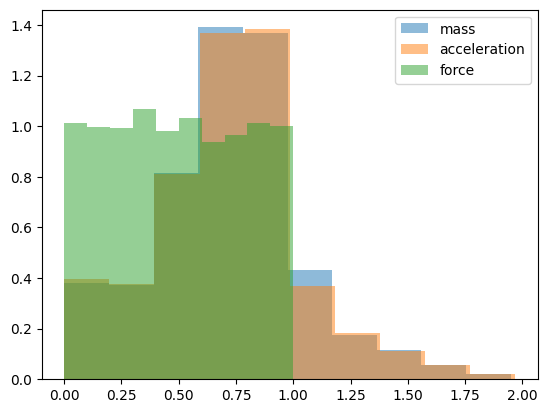

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

In [6]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Training

I'll just do full gradient descent to keep things simple.

In [7]:
N = 4000  # number of epochs

model = Net(use_act=True, dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-3)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [8]:
def plot_loss(train_loss, valid_loss):
    _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs):
    _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()

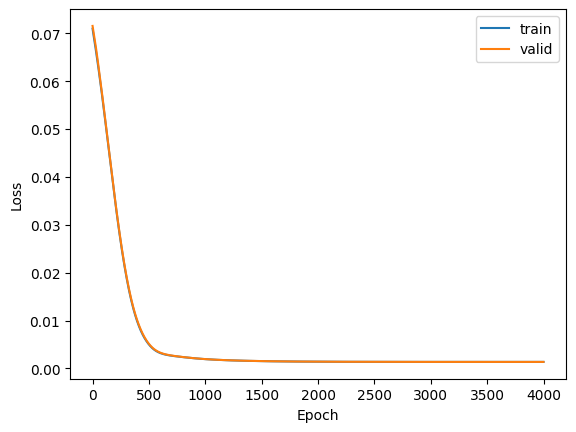

In [9]:
plot_loss(df["train_loss"], df["valid_loss"])

In [10]:
y_preds, y_targs = get_preds(model)

In [11]:
get_valid_loss(model, loss_func)

tensor(0.0014)

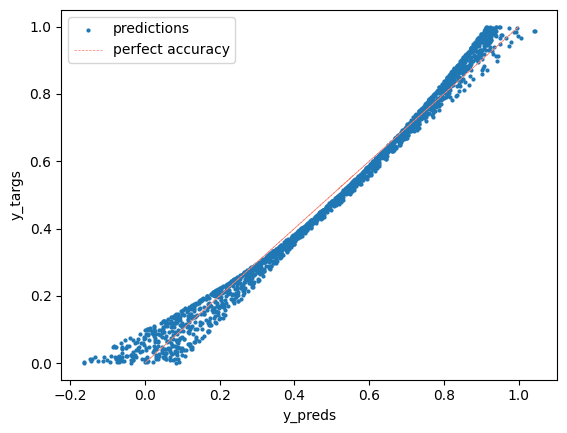

In [12]:
plot_results(y_preds, y_targs)

## Introspection

In [13]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=2, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=2, out_features=1, bias=True)
    )
  )
)

In [14]:
for name, param in model.named_parameters():
    print(name, "\n", param.data, "\n")

layers.0.linear.weight 
 tensor([[ 0.4373, -0.4425],
        [-0.7523, -0.4695]]) 

layers.0.linear.bias 
 tensor([-0.0023,  1.6139]) 

layers.1.linear.weight 
 tensor([[-0.7446, -1.1377]]) 

layers.1.linear.bias 
 tensor([1.3982]) 



### Inspect intermediate values

Going to go operation by operation to see if I can see what's going on.

input ($\rightarrow$ prebias_preacts $\rightarrow$ preacts $\rightarrow$ acts) ($\rightarrow$ prebias $\rightarrow$ output)

(with the layers grouped in brackets)

In [15]:
SD = model.state_dict()

In [44]:
from collections import OrderedDict


def model_breakdown(x1, x2, print_steps=True, return_steps=False):
    x1, x2 = float(x1), float(x2)

    x = torch.tensor([[x1, x2]]).T
    prebias_preacts = torch.matmul(SD["layers.0.linear.weight"], x)
    preacts = prebias_preacts[:, 0] + SD["layers.0.linear.bias"]
    acts = torch.nn.functional.relu(preacts)
    prebias = torch.matmul(SD["layers.1.linear.weight"], acts)
    output = prebias + SD["layers.1.linear.bias"]

    if print_steps:
        print("Input:", "\n", x, "\n")

        print("================ Layer 0 ================", "\n")
        print("Weight:", "\n", SD["layers.0.linear.weight"], "\n")
        print("Result:", "\n", prebias_preacts, "\n")
        print("Bias:", "\n", SD["layers.0.linear.bias"], "\n")
        print("Result:", "\n", preacts, "\n")
        print("Activations:", "\n", acts, "\n")

        print("================ Layer 1 ================", "\n")
        print("Weight:", "\n", SD["layers.1.linear.weight"], "\n")
        print("Result:", "\n", prebias, "\n")
        print("Bias:", "\n", SD["layers.1.linear.bias"], "\n")
        print("Output:", "\n", output, "\n")

        print(f"y_true = {x1*x2:.3f}")

    if return_steps:
        return prebias_preacts, preacts, acts, prebias, output


def plot_model_breakdown(
    x1,
    x2,
    ax=None,
    legend=True,
    color=None,
    product_color=False,
    point_selector={
        "input": True,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
):
    if not ax:
        fig = plt.figure()
        ax = plt.axes()

    input = (x1, x2)

    if not color and product_color:
        val = x1 * x2
        cmap = cm.plasma
        val = val**0.5  # looks better on the unit square with some scaling
        color = cmap(val)

    prebias_preacts, preacts, acts, prebias, output = model_breakdown(*input, print_steps=False, return_steps=True)

    x = OrderedDict()
    x["input"] = input
    x["prebias_preacts"] = prebias_preacts.flatten().tolist()
    x["preacts"] = preacts.flatten().tolist()
    x["acts"] = acts.flatten().tolist()
    x["prebias"] = [float(prebias), 0]
    x["output"] = [float(output), 0]

    markers = {}
    markers["input"] = "v"
    markers["prebias_preacts"] = "o"
    markers["preacts"] = "o"
    markers["acts"] = "o"
    markers["prebias"] = "o"
    markers["output"] = "x"

    for point_name, point in x.items():
        if point_selector[point_name]:
            ax.scatter(*point, alpha=1.0, label=point_name, color=color, marker=markers[point_name])

    x_arr = np.array(list(x.values()))

    ax.plot(*x_arr.T, lw=0.5, color=color)
    ax.set(xlabel="component 0", ylabel="component 1")
    if legend:
        ax.legend()


def get_colors(N):
    cmap = plt.get_cmap("turbo", N)
    colors = []
    for i in range(cmap.N):
        colors.append(cmap(i))
    return colors

In [45]:
model_breakdown(0.75, 1.0)

Input: 
 tensor([[0.7500],
        [1.0000]]) 

================ Layer 0 ================ 

Weight: 
 tensor([[ 0.4373, -0.4425],
        [-0.7523, -0.4695]]) 

Result: 
 tensor([[-0.1145],
        [-1.0337]]) 

Bias: 
 tensor([-0.0023,  1.6139]) 

Result: 
 tensor([-0.1168,  0.5802]) 

Activations: 
 tensor([0.0000, 0.5802]) 

================ Layer 1 ================ 

Weight: 
 tensor([[-0.7446, -1.1377]]) 

Result: 
 tensor([-0.6600]) 

Bias: 
 tensor([1.3982]) 

Output: 
 tensor([0.7381]) 

y_true = 0.750


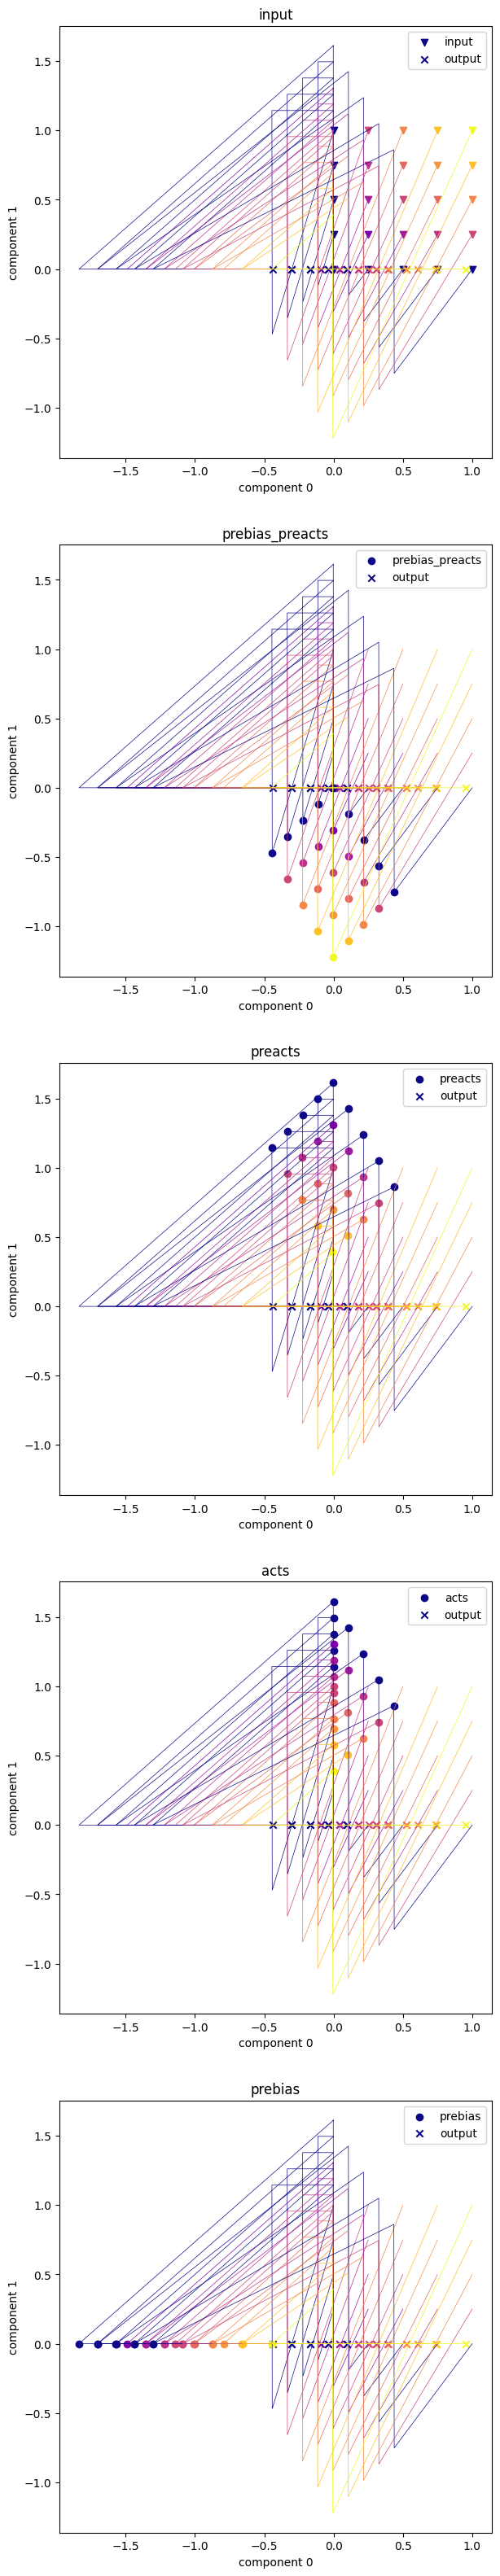

In [46]:
fig, axes = plt.subplots(5, 1, figsize=(10, 40))

N = 5
pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

# cols = get_colors(len(pairs))

subsets = [
    {
        "input": True,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": True,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": True,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": False,
        "acts": True,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": True,
        "output": True,
    },
]

titles = ["input", "prebias_preacts", "preacts", "acts", "prebias"]

for ax, subset, title in zip(axes.flatten(), subsets, titles):
    plot_model_breakdown(*pairs[0], ax, product_color=True, point_selector=subset)
    for pair in pairs[1:]:
        plot_model_breakdown(*pair, ax, legend=False, product_color=True, point_selector=subset)
    ax.set_title(title)
    ax.set_aspect("equal")

This seems like a really clean algorithm to me - perhaps near optimal? How do we really know?

Some things that stand out:
1. I changed the point colouring to correlate with the product of the inputs i.e. where we'd like our final value to sit on the x-axis. It helps us see how the model is gradually reordering the colours with each successive operation.
1. I becoming increasingly confident that the hypothesis of the projection happening in two steps (ReLU and final Linear) is true (at least with this network)
1. Further to this, here we can see that the ReLU acts as a very simplified projection for the negative values, where all the magnitude of x information is essentially lost where points who have a smaller product overlap with those with higher products. This feels probably like the best the model can do here given the tools it has available (i.e. an untrainable ReLU). With this in mind, **a thought:** I wonder (probably like many before me) whether a parametric ReLU would help here? Even if it were just one parameter for the gradient of the negative section? Could be an interesting experiment.
1. The second projection (the genuine one) is more expressive than the ReLU, although I suppose it doesn't have the benefit of being able to selectively operate on a subsample of the points and only really works well once the previous values have been (somewhat) linearly separated into two groups (by the ReLU) so they can be manipulated (somewhat) independently of each other (i.e. those with a non-zero x-component and those without) 🤔. Anyway, it can use the fact that the hidden layer has transformed the points such that those with a lower associated product (the darker points in the `acts` plot) have not only, in general, a higher y-value, but _also_ a higher x-value. These two facts are used to project those points to sit closer to the others that have already been projected to 1-d.

Questions/ideas that remain:
1. The shearing - must have some significance? Perhaps it could be to do with the asymmetry of the projection operations? Maybe it's more to do with the fact that the input distribution isn't uniform (could test this).
1. Similar to above, would have expected something more symmetrical at the `preacts` stage to be more optimal, could play around with this.
1. I wonder if a larger shear operating on the diagonal between the bottom left and top right (of the input unit square) would work better to separate the low from high values? This would at least act to group the bottom and top 1/2 of the products separately.

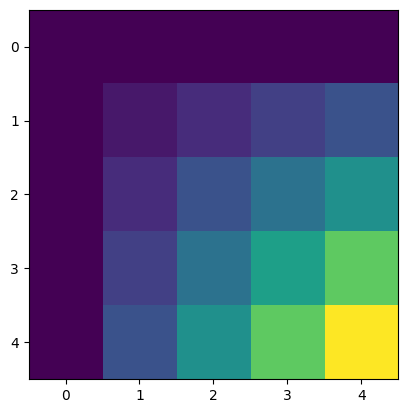

In [19]:
D = pairs.reshape(N, N, -1)
Dy = D[:, :, 0] * D[:, :, 1]
plt.imshow(Dy)

So by aligning these in the final projection, you might expect to get closer to a better result.

There remain two questions in my head:
1. the zero columns obviously break this (rough) symmetry. Is that important? Has the network learnt a mechanism to deal with this?
1. whilst the diagonals share _roughly_ the same values, perhaps there's something extra the network does / can do in order to model the iso-curves better. 

## Looking in more detail at the iso-curves

[Text(0.5, 0, '$x$'), Text(0, 0.5, '$y$')]

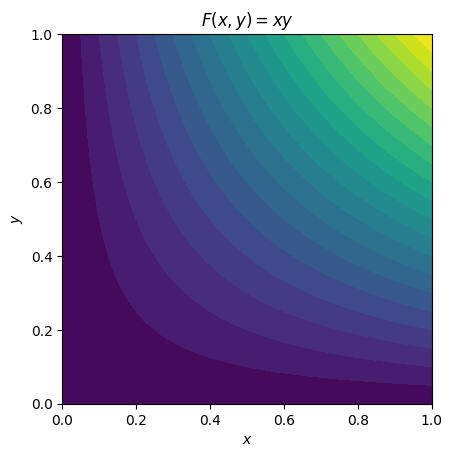

In [20]:
N = 1000
pairs = np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))
B = pairs[0]
C = pairs[1]
D = pairs[0] * pairs[1]

fig, ax = plt.subplots()
ax.contourf(B, C, D, 20, cmap="viridis")
ax.set_aspect("equal")
ax.set_title("$F(x,y)=xy$")
ax.set(xlabel="$x$", ylabel="$y$")

So from this, we'd expect a transformation that could "straighten" these contours to be effective when then coupled with some kind of rotation and translation in order to perform the projection down to 1 dimension.

## Additional analysis

Let's see if I can make any sense of the operation with SVD:

In [21]:
W = SD["layers.0.linear.weight"]
U, S, V = torch.svd(W)
theta_U = torch.atan2(U[1, 0], U[0, 0]) / torch.pi
theta_V = torch.atan2(V.T[1, 0], V.T[0, 0]) / torch.pi
theta_U, S, theta_V

(tensor(0.5868), tensor([0.9057, 0.5942]), tensor(0.8802))

Step by step, this is:

In [22]:
p1 = torch.tensor([1.0, 1.0])
p2 = torch.matmul(V.T, p1)
p3 = torch.matmul(S * torch.eye(2), p2)
p4 = torch.matmul(U, p3)
p1, p2, p3, p4

(tensor([1., 1.]),
 tensor([-1.2976, -0.5624]),
 tensor([-1.1752, -0.3342]),
 tensor([-0.0052, -1.2218]))

In [23]:
torch.linalg.eig(W)

torch.return_types.linalg_eig(
eigenvalues=tensor([ 0.7177+0.j, -0.7499+0.j]),
eigenvectors=tensor([[ 0.8447+0.j,  0.3492+0.j],
        [-0.5352+0.j,  0.9370+0.j]]))

Not a very interpretable diagram:

In [24]:
# SD = model.state_dict()
# weight = SD["layers.0.linear.weight"].numpy()
# bias = SD["layers.0.linear.bias"].numpy()

# fig, ax = plt.subplots()

# sc = ax.scatter(*weight.T, c=bias, cmap="coolwarm")

# # Add a colorbar
# cbar = fig.colorbar(sc, ax=ax, label="bias")

# ax.set(xlabel="Component 0", ylabel="Component 1")

# ax.axvline(0, color="k", linestyle="--", linewidth=0.5)
# ax.axhline(0, color="k", linestyle="--", linewidth=0.5)

How's this actually going to _transform_ the input?

In [25]:
def get_preds_range(x2=0.5):
    # True solution
    x1 = np.linspace(0, 1, 50)
    x2 = np.repeat(x2, 50)
    y = x1 * x2

    # Predicted solution
    with torch.inference_mode():
        x = torch.stack([torch.as_tensor(x1), torch.as_tensor(x2)]).T.float()
        y_hat = model(x)
        y_hat = y_hat.detach().numpy()

    return y_hat, y


def get_preds_multi_range():
    x2s = np.linspace(0, 1, 11)
    rows = []
    for x2 in x2s:
        row = {"x2": x2}
        row["y_hat"], row["y"] = get_preds_range(x2=x2)
        rows.append(row)
    return rows

In [26]:
results = get_preds_multi_range()

Fixing $x_2$ and varying $x_1$ to isolate behaviour:

In [27]:
# fig, ax = plt.subplots(figsize=(10, 10))

# for row in results:
#     ax.plot(row["y_hat"], row["y"], lw=1, label=f"x2 = {row['x2']:.2f}")

# ax.plot([0, 1], [0, 1], color="salmon", lw=2, ls="--", label="perfect accuracy")
# ax.set(xlabel="y_preds", ylabel="y_targs")
# ax.legend()